# System Identification using the Ho-Kalman method

### Imports

Note, for MIMO systems, package slycot must be installed as well.

In [100]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import control_matrices as cm
import control as ct 
from matrepr import mdisplay, to_latex
from IPython.display import display, Latex, HTML

### System
Here, the true state space system $\Sigma$ is created. In reality, we wouldn't know this system or the matrices
defining it. The system is defined as:
$$
    x[k+1] = Ax[k] + Bu \\
    y[k] = Cx[k] + Du
$$
where $A \in \mathbb{R}^{n\times n}, B \in \mathbb{R}^{n\times p}, C \in \mathbb{R}^{q\times n}, D \in \mathbb{R}^{q\times p}$,\
$x \in \mathbb{R}^{n\times 1}, u \in \mathbb{R}^{p\times 1}$ and $y \in \mathbb{R}^{q\times 1}$.\
$n$ is the system order, $p$ the number of inputs and $q$ the number of outputs.

In [101]:
# %% System
A = np.array([[0,1,0,0],
              [-0.5,-0.4,0,-0.5],
              [0,0,0.2,-1],
              [0,0,0,-0.8]]
              )

B = np.array(
    [[0,0],
     [0,1],
     [0,0],
     [1,0]]
)
C = np.array(
    [[1,0,0,0],
     [0,0,2,0]]
    )
D = np.array([[0,0],[0,0]])

In [102]:
display(HTML(r'<h3>System Definition and stability </h3>'))

# This line will raise an error if state space is not
# appropriately dimensioned.
cm.check_state_space_dimensions(A, B, C, D)

display(Latex(r'$A = ' + to_latex(A) + '$, ' + r'$B = ' + to_latex(B) + '$'))
display(Latex(r'$C = ' + to_latex(C) + '$, ' + r'$D = ' + to_latex(D) + '$'))

# We will need the dimensions of the system later.
# p and q is known, but not n.
n = A.shape[0]
p = B.shape[1]
q = C.shape[0]

# Some sanity checks on the system.
truePoles = np.sort_complex(np.linalg.eigvals(A))

if np.all(np.abs(truePoles) < 1):
    stablestr = "A is stable."
else:
    stablestr = "A is not stable."
mdisplay(np.real_if_close(truePoles),title="Poles, " + stablestr)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0,1,2,3
-0.8+0i,-0.2--0.6782i,-0.2+0.6782i,0.2+0i


### Checking controllability and observability

In [103]:
display(HTML(r'<h3>System Controllability and Observability </h3>'))

ctr = cm.make_controllability_matrix(A, B)
ctr_rank = np.linalg.matrix_rank(ctr)
ctr_str = fr"=n={n}\rightarrow$ Controllable" if ctr_rank==n else fr"<n={n}\rightarrow$ Not Controllable"
#mdisplay(ctr, title="'Controllability Matrix")
display(Latex(fr"$rank(\mathcal{{C}})={ctr_rank}" + ctr_str))

obs = cm.make_observability_matrix(A, C)
obs_rank = np.linalg.matrix_rank(obs)
obs_str = fr"=n={n}\rightarrow$ Observable" if obs_rank==n else fr"<n={n}\rightarrow$ Not Observable"
#mdisplay(obs, title="'Observability Matrix")
display(Latex(fr"$rank(\mathcal{{O}})={obs_rank}" + obs_str))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Input-output data
Here, we're gathering $N$ input-output data samples which will be used to identify the system. \
White noise uniform is used as an input signal, for reasons that are explained in the next cell.

[]

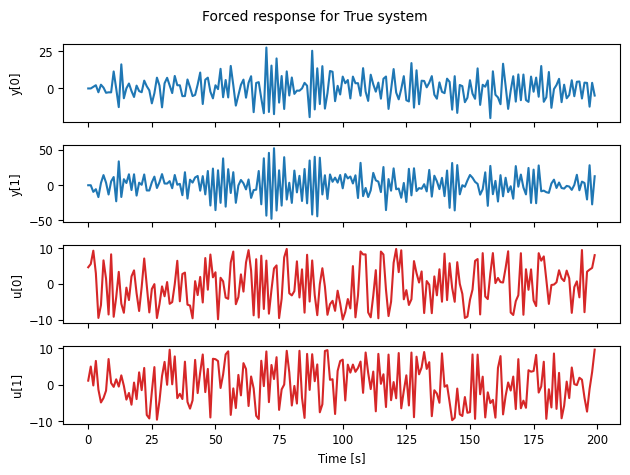

In [115]:
display(HTML(r'<h3> System Input-Output response </h3>'))

### Parameters for input data and system simulation.

# Nr of input samples. Much easier if the number of outputs q is a divisor.
N = 100*q
# Input signal(s).
# White noise usually makes for a well conditioned matrix.
u = np.random.uniform(-10, 10, size=(p,N))

true_sys = ct.ss(A,B,C,D,dt=True, name='True system')
resp = ct.forced_response(true_sys,U=u)
resp.plot()
plt.plot()

### Forming the Hankel Matrices

Now, we use the input-output data to form the Hankel Matrices $U$ and $Y$ in the equation

$$
% Equation
Y = \mathcal{O}_tX + \mathcal{T}_tU\\[2pt]
\Updownarrow \\[4pt]
% Y
\underbrace{
  \left[ \begin{array}{cccc}
    y[0] & y[1] & \cdots & y[N-t-1] \\
    y[1] & y[2] & \cdots & y[N-t]   \\
    \vdots & \vdots & \ddots &  \\
    y[t-1] & y[t] & \cdots & y[N-1]
  \end{array} \right]
}_Y
% Ext. Obs.
=
\underbrace{
  \left[ \begin{array}{c}
    C \\ CA \\ \vdots \\ CA^{t-2}
  \end{array} \right]
}_{\mathcal{O}_t}
% X
\underbrace{
  \left[ \begin{array}{cccc}
    x[0] & x[1] & \cdots & x[N-1]
  \end{array} \right]
}_X
% Toeplitz 
+ \\[6pt] +
\underbrace{
  \left[ \begin{array}{cccc}
    D & 0 & \cdots & 0 \\
    CB & D & \cdots & 0 \\
    \vdots & \vdots & \ddots & \\
    CA^{t-3}B & CA^{t-4}B & \cdots & D
  \end{array} \right]
}_{\mathcal{T}_t}
% U
\underbrace{
  \left[ \begin{array}{cccc}
    u[0] & u[1] & \cdots & u[N-t-1] \\
    u[1] & u[2] & \cdots & u[N-t]   \\
    \vdots & \vdots & \ddots &  \\
    u[t-1] & u[t] & \cdots & u[N-1]
  \end{array} \right]
}_U
$$

where $t$ denotes the number of block rows in the equation. \
This is a free parameter but should be set such that $t, (N-t) > n$ and $t\times q < N$,
so that $U$ and $Y$ are underdetermined matrices. In other words, they must have more rows than columns, 
and both the number of block rows and block columns must be greater than the system order $n$. Below, it is set so that $t = 2q$. \
Furthermore, $u[t]$ must be persistently exciting, meaning $U$ must be of full rank. For this reason, random white noise is used for an input signal.

In [116]:
display(HTML(r'<h3> Input-output Hankel matrices </h3>'))
t = int(N/(2*q))
U = cm.make_Hankel_matrix(u,t,1,p)
Y = cm.make_Hankel_matrix(resp.y, t, 1, q)
Up = U[:int(q*t/2),:]
Yp = Y[:int(q*t/2),:]
Uf = U[int(q*t/2):,:]
Yf = Y[int(q*t/2):,:]
Wp = np.concatenate([Up, Yp],axis=0)

Upp = U[:int(q*t/2)+p,:]
Ypp = Y[:int(q*t/2)+q,:]
Ufm = U[int(q*t/2)+p:,:]
Yfm = Y[int(q*t/2)+q:,:]
Wpp = np.concatenate([Upp, Ypp],axis=0)

display(Latex('$U = ' + to_latex(U)+'$'))
display(Latex('$Y = ' + to_latex(Y)+'$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Extracting $\mathcal{\hat{O}}_t$, estimating system matrices ${\hat{A}}$ and $\hat{C}$
Next, we're calculating the projection of the nullspace of $U$, $\Pi_U^{\perp}$
$$
\begin{align*}
\Pi_U^{\perp} &= I - U^{\dagger}U \\
U\Pi_U^{\perp} &= 0 = U - \underbrace{UU^{\dagger}}_{I}U, \:
\text{(Holds if $U$ is full rank and underdetermined.)}
\end{align*}
$$
We then right-multiply this projection with $Y = \mathcal{O}_tX + \mathcal{T}_tU$ to remove the right term and get $G=\mathcal{O}_tX \Pi_U^{\perp}$
$$
G = Y\Pi_U^{\perp} = \mathcal{O}_tX \Pi_U^{\perp} + \mathcal{T}_tU \Pi_U^{\perp} = \mathcal{O}_tX \Pi_U^{\perp} + 0
$$
With the right term removed, we need to factor $G$ into its components $\mathcal{O}_t$ and $X \Pi_U^{\perp}$. \
We do this by taking the singular value decomposition of $G$
$$
G = U_G S_G V^T_G \\
S_G = \left[ \begin{array}{ccc}
    \sigma_1 & & 0 \\
     & \ddots & \\
    0 & & \sigma_{\hat{n}}
\end{array} \right], \: \text{$\hat{n}$ is the estimated system order}
$$
$\hat{\mathcal{O}}_t$ can now be obtained with the ansatz:
$$
G = U_G S_G V^T_G = \underbrace{U_G (S_G)^{\frac{1}{2}}}_{\hat{\mathcal{O}}_t} \underbrace{(S_G)^{\frac{1}{2}}V^T_G}_{X\Pi_U^{\perp}}
$$
While the equation $Y = \mathcal{O}_tX + \mathcal{T}_tU$ in no way has a unique solution given $U$ and $Y$, it does not matter. \
The estimated system matrices that we will get are not likely to be the same as the true
system matrices. \
If the input-output data is good however, they should be related to a
similar system $\hat{\Sigma}$ through the relations:
$$
  \hat{A} = T^{-1}AT, \hat{B} = T^{-1}B, \hat{C} = CT, \hat{D} = D
$$
where T is an invertible similarity matrix. $\hat{\Sigma}$ will have the same input-output relation and poles as the original system $\Sigma$.
<br>
<br>
With $\hat{\mathcal{O}}_t$ in hand, we can get $\hat{A}$ and $\hat{C}$.
We construct two new matrices from $\hat{\mathcal{O}}_t$.

$$
\hat{\mathcal{O}}_{0,t-1} =
  \left[ \begin{array}{c}
    \hat{C} \\ \hat{C}\hat{A} \\ \vdots \\ \hat{C}\hat{A}^{t-3}
  \end{array} \right], \: 
\hat{\mathcal{O}}_{1,t} =
  \left[ \begin{array}{c}
    \hat{C}\hat{A} \\ \hat{C}\hat{A}^2 \\ \vdots \\ \hat{C}\hat{A}^{t-2} = 
  \end{array} \right]
  = \hat{\mathcal{O}}_{0,t-1}\hat{A}
$$
We get $\hat{C}$ directly from the first $q$ rows of $\mathcal{O}_{0,t-1}$, and $\hat{A}$ from
$$
\hat{\mathcal{O}}_{1,t} = \hat{\mathcal{O}}_{0,t-1}\hat{A} \Leftrightarrow \hat{A} = \hat{\mathcal{O}}_{0,t-1}^{\dagger} \hat{\mathcal{O}}_{1,t}
$$

In [117]:
# Finding G from Y by multiplying with null space of U
PI_Uf = np.eye(Uf.shape[1]) - np.linalg.pinv(Uf)@Uf
G = (Yf@PI_Uf)@np.linalg.pinv(Wp@PI_Uf)@Wp

PI_Ufm = np.eye(Ufm.shape[1]) - np.linalg.pinv(Ufm)@Ufm
Gm1 = (Yfm@PI_Ufm)@np.linalg.pinv(Wpp@PI_Ufm)@Wpp

# Taking the SVD of G
U_G, s_G, Vh_G = np.linalg.svd(G)
s_G_cutoff = s_G[s_G > np.max(s_G)*1e-3]
n_hat = s_G_cutoff.size
S_G = np.diag(s_G_cutoff)

# Getting the extended observability matrix, estimating A and C
Obs = (U_G[:,:n_hat]@sqrtm(S_G))
Obs_m1 = Obs[:-q,:]

Gm1.shape

(48, 151)

In [120]:
Xi0 = np.linalg.pinv(Obs)@G
Xi1 = np.linalg.pinv(Obs_m1)@Gm1
j = Xi0.shape[1]
Yii = resp.y[:,-(j+1):-1]
Uii = u[:,-j:]

H1 = np.concatenate([Xi1, Yii], axis=0)
H2 = np.concatenate([Xi0, Uii], axis=0)
ABCD = H1@np.linalg.pinv(H2)
mdisplay(Xi0)
mdisplay(Xi1)
mdisplay(ABCD)

# display(Latex(r'$y_0 = ' + f'{resp.y[:,0]}' + r'$;$ \hat{y}_0 = ' + f'{C_hat@np.reshape(params[:n],(n,1)) + D@np.reshape(u[:,0],(p,1))}' + r'$'))
# display(Latex(r'$\hat{A} = ' + to_latex(A_hat) + '$, ' + r'$\hat{B} = ' + to_latex(B_hat) + '$'))
# display(Latex(r'$\hat{C} = ' + to_latex(C_hat) + '$, ' + r'$\hat{D} = ' + to_latex(D_hat) + '$'))

,0,1,2,3,4,5,6,,144,145,146,147,148,149,150
0,-0.6014,0.6551,-0.3748,-0.9033,0.3777,-0.02205,-0.2749,⋯,-1.035,0.7216,0.5995,-1.888,2.293,-2.094,2.232
1,1.239,0.7518,-0.109,0.5128,1.542,0.4469,0.2677,⋯,0.1053,1.229,-1.736,0.9216,0.2067,-0.09879,-0.2473
2,0.4342,-0.2221,-0.5819,-0.7831,0.3308,-0.4997,-0.9263,⋯,-1.144,0.05127,-0.4113,0.7956,0.2054,-0.006274,-0.3023
3,-1.194,0.2373,0.6446,-1.73,-0.8814,0.8245,0.3954,⋯,-0.5825,0.116,-0.0759,-1.267,-0.09725,0.7505,0.2536


,0,1,2,3,4,5,6,,144,145,146,147,148,149,150
0,0.6551,-0.3748,-0.9033,0.3777,-0.02205,-0.2749,0.3974,⋯,0.7216,0.5995,-1.888,2.293,-2.094,2.232,-2.481
1,0.7518,-0.109,0.5128,1.542,0.4469,0.2677,-0.2604,⋯,1.229,-1.736,0.9216,0.2067,-0.09879,-0.2473,0.1312
2,-0.2221,-0.5819,-0.7831,0.3308,-0.4997,-0.9263,-0.3951,⋯,0.05127,-0.4113,0.7956,0.2054,-0.006274,-0.3023,-0.06149
3,0.2373,0.6446,-1.73,-0.8814,0.8245,0.3954,-0.3964,⋯,0.116,-0.0759,-1.267,-0.09725,0.7505,0.2536,0.2705


,0,1,2,3,4,5
0,-0.9175,0.1802,-0.07639,-0.07989,0.01445,0.008763
1,-0.1734,-0.0838,0.0001105,-0.5159,-0.014,-0.004082
2,0.03979,-0.6588,0.004791,-0.5749,0.005731,0.003288
3,0.06819,0.1481,0.3933,-0.07924,0.007129,0.01297
4,1.154,0.9157,0.3506,-0.9652,-0.09652,-0.08189
5,-3.013,0.6561,1.453,0.7733,0.5477,0.1815
